Song, Shim, Rosenberg (2022) Large-scale neural dynamics in a shared low-dimensional state space reflect cognitive and attentional dynamics<br>
code created by: Hayoung Song (hyssong@uchicago.edu), March 27, 2022

The code generates **Figure 2** of the paper

In [1]:
import numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
nstate  = 4
nsubj   = 27
nR      = 25
loaddir = '../'
condition=['rest1','rest2','gradCPTface','gradCPTscene','sitcomep1','sitcomep2','documentary']

In [3]:
# color palettes by: https://github.com/BlakeRMills/MetBrewer
Cassatt2=dict(colors=("#2d223c", "#574571", "#90719f", "#b695bc", "#dec5da", "#c1d1aa", "#7fa074", "#466c4b", "#2c4b27", "#0e2810"), colorblind=True)
thinline, thickline = Cassatt2['colors'][2], Cassatt2['colors'][0]

## Cofluctuation time-aligned to neural state transitions (Figure 2a)

In [4]:
# categorize pairwise ROIs into: cortico-cortical, cortico-subcortical, and subcortico-subcortical connections
netid = []
for n1 in range(1,nR):
    for n2 in range(n1+1,nR+1):
        if n1<=17 and n2<=17:
            netid.append([n1,n2,0])
        elif (n1<=17 and n2>17) or (n1>17 and n2<=17):
            netid.append([n1,n2,1])
        elif n1>17 and n2>17:
            netid.append([n1,n2,2])
netid=np.array(netid)

In [5]:
# Cofluctuation, or edge functional connectivity (Esfahlani et al., 2020; Faskowitz et al., 2020), computes pairwise 
# regions' degree of cofluctuation at every time step by taking the absolute of the element-wise product of the two 
# regions' z-normalized time series
cofluc=[]
for cdt in condition:
    for subj in range(nsubj):
        if cdt=='sitcomep1' and subj==25:
            pass
        else:
            # load 25 ROI time series and HMM latent state sequence
            seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt][subj,:]
            ts = scipy.stats.zscore(scipy.io.loadmat(loaddir+'fmri/ts_'+cdt+'.mat')['ts'][subj,:,:], axis=0, ddof=1)
            nT = ts.shape[0]

            # compute absolute element-wise product of every pair of ROI time series
            dynets = np.zeros((int(nR*(nR-1)/2), int(nT)))
            ii=-1
            for n1 in range(nR-1):
                for n2 in range(n1+1,nR):
                    ii=ii+1
                    dynets[ii,:] = np.abs(np.multiply(ts[:,n1],ts[:,n2]))

            # compile cofluctuation time series (t-3 to t+3) that align to latent state transitions, then average
            aligned=[]
            for t in range(3,nT-3):
                if seq[t-1]!=seq[t]:
                    aligned.append(dynets[:,t-3:t+3+1])
            aligned = np.mean(np.array(aligned),0)
            cofluc.append(aligned)
cofluc=np.array(cofluc)
print('cofluctuation aligned to neural state transition: '+str(cofluc.shape))
# cofluc: 188 (all participants' all fMRI runs) * 300 (# paired ROI) * 7 (t-3 to t+3)

cofluctuation aligned to neural state transition: (188, 300, 7)


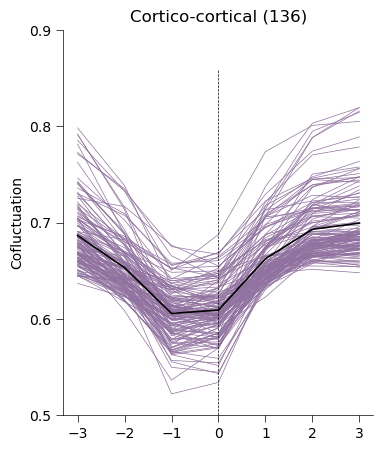

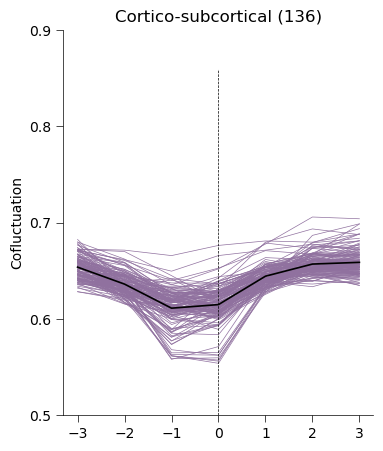

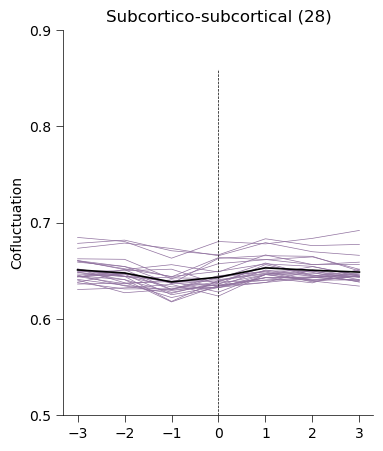

In [6]:
typename = ['Cortico-cortical','Cortico-subcortical','Subcortico-subcortical']
for type in range(3): # cortico-cortical, cortico-subcortical, subcortico-subcortical
    fig, ax1 = plt.subplots(1,1, figsize=(4,5))
    vals = cofluc[:,np.where(netid[:,2]==type)[0],:]
    vals = np.mean(vals,0)
    ax1.vlines(0,0.5,0.86,colors='k',linestyles='--',linewidths=0.5)
    for i in range(vals.shape[0]):
        ax1.plot(np.arange(-3,3+1), vals[i,:],thinline,linewidth=0.5,zorder=1)
    ax1.plot(np.arange(-3,3+1), np.mean(vals,0),'k',linewidth=1.2,zorder=2)
    ax1.set_xticks([-3,-2,-1,0,1,2,3])
    ax1.set_yticks([0.5,0.6,0.7,0.8,0.9])
    ax1.set_ylim([0.5,0.9])
    ax1.set_ylabel('Cofluctuation')
    ax1.tick_params(length=5, width=0.5)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_linewidth(0.5)
    ax1.spines['left'].set_linewidth(0.5)
    ax1.set_title(typename[type]+' ('+str(np.where(netid[:,2]==type)[0].shape[0])+')')
    plt.show()

## Cofluctuation at latent states (Figure 2c)

In [7]:
cmap = np.array([[219 / 255, 68 / 255, 55 / 255],
    [57 / 255, 0 / 255, 216 / 255],
    [15 / 255, 157 / 255, 88 / 255],
    [255 / 255, 215 / 255, 0 / 255]])

In [8]:
statecofluc=[]
for cdt in condition:
    for subj in range(nsubj):
        if cdt=='sitcomep1' and subj==25:
            pass
        else:
            # load 25 ROI time series and HMM latent state sequence
            seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt][subj,:]
            ts = scipy.stats.zscore(scipy.io.loadmat(loaddir+'fmri/ts_'+cdt+'.mat')['ts'][subj,:,:], axis=0, ddof=1)
            nT = ts.shape[0]

            # compute absolute element-wise product of every pair of ROI time series
            dynets = np.zeros((int(nR*(nR-1)/2), int(nT)))
            ii=-1
            for n1 in range(nR-1):
                for n2 in range(n1+1,nR):
                    ii=ii+1
                    dynets[ii,:] = np.abs(np.multiply(ts[:,n1],ts[:,n2]))
            dynets = np.mean(dynets,0)

            # categorize TRs based on latent state identification, and average
            hmm = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt][subj,:]
            stcof = []
            for stt in range(1,nstate+1):
                stcof.append(np.mean(dynets[np.where(hmm==stt)[0]]))
            statecofluc.append(stcof)
statecofluc=np.asarray(statecofluc)
print('cofluctuation categorized based on latent states: '+str(statecofluc.shape))
# staetcofluc: 188 (all participants' all fMRI runs) * 4 (number of latent states)

cofluctuation categorized based on latent states: (188, 4)


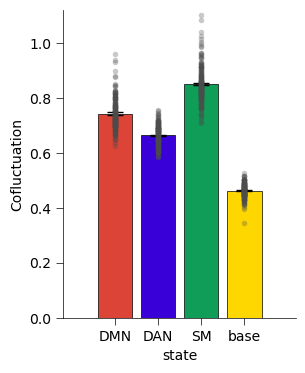

In [9]:
# to plot individual data points
valus = np.concatenate((statecofluc[:,0], statecofluc[:,1],statecofluc[:,2],statecofluc[:,3]),0)
categ = np.concatenate((np.repeat('state1',statecofluc.shape[0]), np.repeat('state2',statecofluc.shape[0]), np.repeat('state3',statecofluc.shape[0]), np.repeat('state4',statecofluc.shape[0])),0)
df = pd.DataFrame(data={'state':categ,'values':valus})

# bar plot
fig, ax = plt.subplots(1,1, figsize=(3,4))
sns.stripplot(x="state", y="values", data=df, color=[0.3,0.3,0.3],jitter=False,alpha=0.3, size=4)
ax.bar(np.arange(nstate),np.mean(statecofluc,0), color=cmap, edgecolor='black',linewidth=0.5)
ax.errorbar(np.arange(nstate),np.mean(statecofluc,0),
             np.std(statecofluc,0)/np.sqrt(statecofluc.shape[0]),
             capsize=6,ecolor='black',ls='none')
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_ylim([0,1.12])
ax.set_xlim([-1.2,4.2])
ax.set_ylabel('Cofluctuation')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['DMN','DAN','SM','base'])
ax.tick_params(length=5, width=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

## Transition matrix (Figure 2b)

In [10]:
transmat=[]
for cdt in condition:
    for subj in range(nsubj):
        if cdt=='sitcomep1' and subj==25:
            pass
        else:
            seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt][subj,:]-1
            
            # For all time steps (T-1), count "from -> to" state transitions
            transsubj = np.zeros((nstate,nstate))
            for t in range(1,len(seq)):
                transsubj[int(seq[t-1]),int(seq[t])] = transsubj[int(seq[t-1]),int(seq[t])] + 1
            
            # Change count matrix to probability matrix
            # Markovian probability: each row sums to 1, which asks "to" which state it is more likely to make transitions.
            for row in range(nstate):
                transsubj[row,:] = transsubj[row,:]/np.sum(transsubj[row,:])
            transmat.append(transsubj)
transmat = np.asarray(transmat)
transmat = np.mean(transmat,0) # mean of all participants' all fMRI runs
print('Markovian transition probability')
print(np.round(transmat,2))
# This transition matrix was compared with a chance distribution in which HMM fits were conducted on the circular-shifted time series

Markovian transition probability
[[0.87 0.03 0.04 0.07]
 [0.03 0.87 0.03 0.07]
 [0.04 0.04 0.86 0.07]
 [0.05 0.05 0.04 0.86]]
